## A/B тест приложения

А/В тест приложения с целю увеличения прибыли. Необходимо проанализировать необработанные данные результа теста, сделать выводы и дать рекомендации.

Этапы проведения анализа данных:


1.   Описание данных
2.   Обработка и подготовка данных для дальнейшего анализа
3.   Анализ данных, постановка гипотез, проверка предположений
4.   Выводы, рекомендации



### Описание данных

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sm
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, pearsonr, spearmanr, kendalltau, f_oneway, kruskal

sns.set_theme(style="darkgrid", palette="deep")

In [ ]:
url = '/content/drive/MyDrive/Datasets/A_B_Test/AB_Test_Results.csv'
data = pd.read_csv(url)

In [ ]:
data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


Набор данных содержит:


*   USER_ID - уникальный идентификатор пользователя
*   VARIANT_NAME - группа пользователей (контрольная группа, тестовая группа)
*   REVENUE - доход, который принес пользователь






In [ ]:
data.shape

(10000, 3)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [ ]:
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


### Обработка и подготовка данных для дальнейшего анализа

Проверка данных на отсутствующие значения

In [ ]:
data.isnull().sum()

,0
USER_ID,0
VARIANT_NAME,0
REVENUE,0


В данных нет отсутствующих значений

Проверка данных на дубликаты

In [ ]:
data.duplicated().sum()

2067

В данных присутствуют дубликаты

Посмотрим количество уникальных пользователей

In [ ]:
data['USER_ID'].nunique() == data.shape[0]

False

Необходимо удалить пользователей, которые встречаются в двух группах

In [ ]:
duplicate_user = data.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1

In [ ]:
duplicate_user = duplicate_user[duplicate_user]

In [ ]:
data = data[data['USER_ID'].isin(duplicate_user.index)]

In [ ]:
data.shape

(6070, 3)

### Анализ данных, постановка гипотез, проверка предположений

Проанализируем количество пользователей в группах

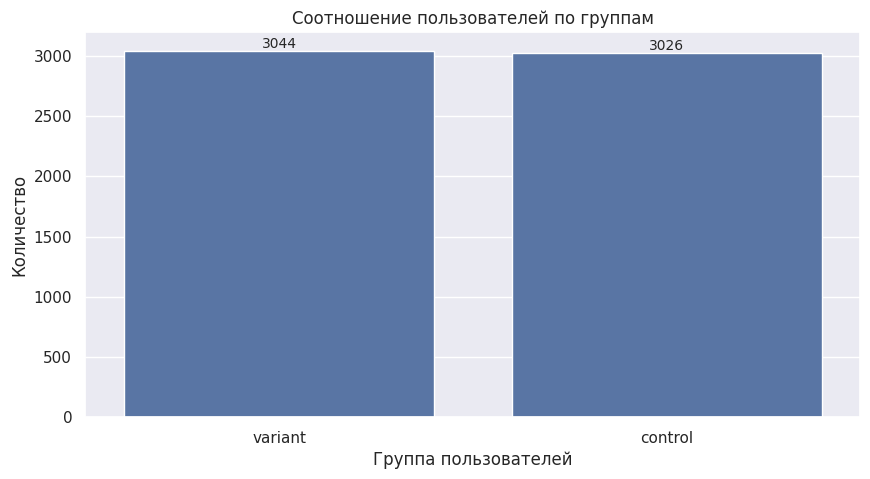

In [ ]:
plt.figure(figsize = (10, 5))
ax = sns.countplot(data = data, x = 'VARIANT_NAME')
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Соотношение пользователей по группам')
plt.xlabel('Группа пользователей')
plt.ylabel('Количество')
plt.show()

Группы пользователей различаются по количеству

Расмотрим статистику по доходам, которые принесли пользователи

In [ ]:
data.describe()[['REVENUE']].T

,count,mean,std,min,25%,50%,75%,max
REVENUE,6070.0,0.107064,2.673501,0.0,0.0,0.0,0.0,196.01


Доверительный интервал значения для среднего

In [ ]:
sm.DescrStatsW(data["REVENUE"]).tconfint_mean()

(0.039794372950474055, 0.17433412787324915)

In [ ]:
data_for_boxplot = data[data['REVENUE'] < 25]

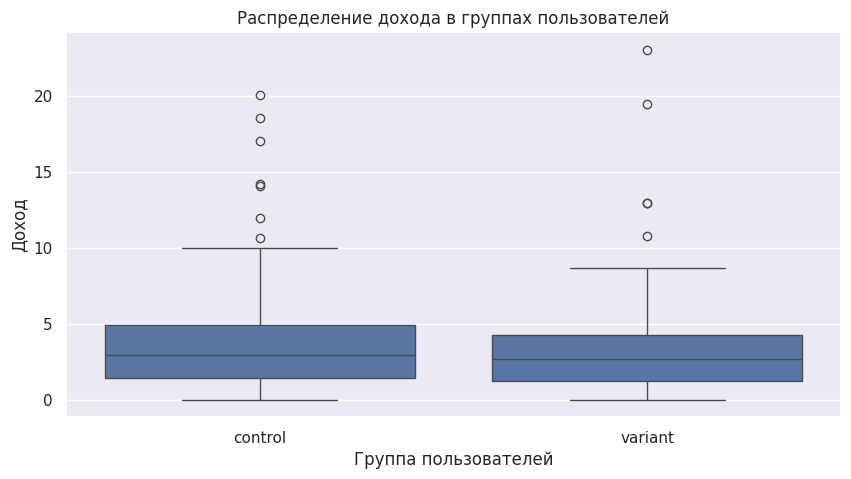

In [ ]:
plt.figure(figsize = (10, 5))
sns.boxplot(data = data_for_boxplot[data_for_boxplot['REVENUE'] > 0], x = 'VARIANT_NAME', y = 'REVENUE')
plt.title('Распределение дохода в группах пользователей')
plt.xlabel('Группа пользователей')
plt.ylabel('Доход')
plt.show()

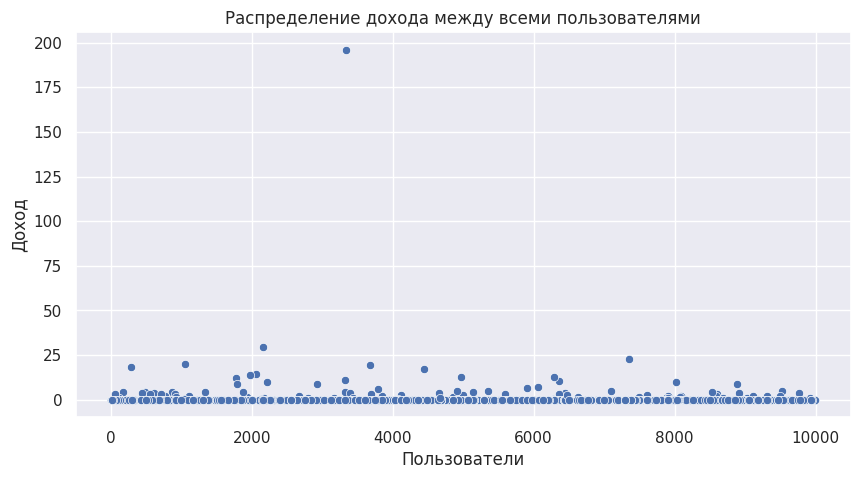

In [ ]:
plt.figure(figsize = (10, 5))
sns.scatterplot(data = data, x = 'USER_ID', y = 'REVENUE')
plt.title('Распределение дохода между всеми пользователями')
plt.xlabel('Пользователи')
plt.ylabel('Доход')
plt.show()

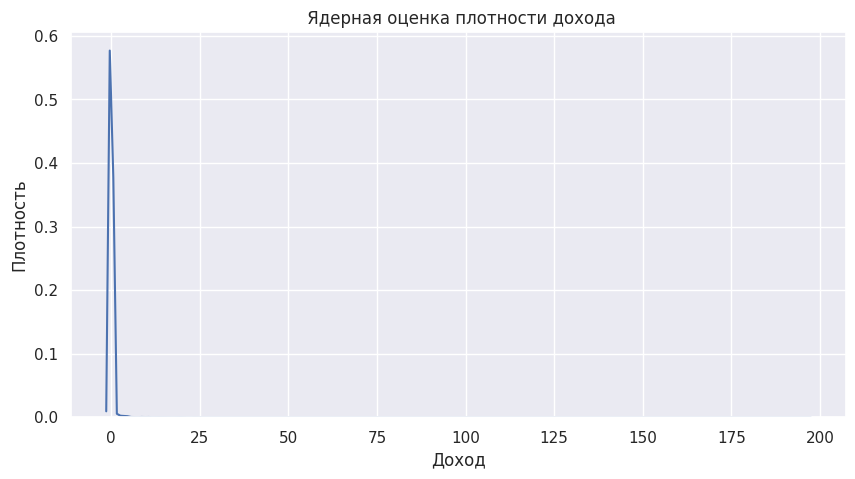

In [ ]:
plt.figure(figsize = (10, 5))
sns.kdeplot(data = data, x = 'REVENUE')
plt.title(' Ядерная оценка плотности дохода')
plt.xlabel('Доход')
plt.ylabel('Плотность')
plt.show()

В обоих группах наблюдается большое количество выбросов

Разобьем датафрейм на два по группам пользователей

In [ ]:
data_control = data.loc[data['VARIANT_NAME'] == 'control']
data_test = data.loc[data['VARIANT_NAME'] == 'variant']

In [ ]:
data_control.head()

,USER_ID,VARIANT_NAME,REVENUE
7,9168,control,0.0
9,7548,control,0.0
10,8395,control,0.0
11,1184,control,0.0
12,7165,control,0.0


In [ ]:
data_test.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
14,3489,variant,0.0
16,7549,variant,0.0


Средние значения дохода по группам:

In [ ]:
data_control['REVENUE'].mean()

0.1555056179775281

In [ ]:
data_test['REVENUE'].mean()

0.05890932982917214

Формируем гипотезы

*  Нулевая гипотеза:

   H0: нет статистически значимой разницы между средним доходом контрольной и тестовой группы (p-value > 0.05)
*  Альтернативная гипотеза:

   H1: наблюдается статистически значимая разница (p-value < 0.05)

Для дальнейшего анализа необходимо проверить данные на:

1.   Нормальное распределение
2.  Однородность дисперсий



Проверка на нормальность (тест Шапиро- Уилка)

*  Нулевая гипотеза:

   H0: Предположение о нормальномти распределения данных выполнено (p-value > 0.05)
*  Альтернативная гипотеза

   H1: Предположение о нормальности распределения данных отклонено (p-value < 0.05)

In [ ]:
test_stat, pvalue = shapiro(data_control['REVENUE'])

In [ ]:
'test_stat = %.4f, p-value = %.4f' % (test_stat, pvalue)

'test_stat = 0.0510, p-value = 0.0000'

In [ ]:
test_stat, pvalue = shapiro(data_test['REVENUE'])

In [ ]:
'test_stat = %.4f, p-value = %.4f' % (test_stat, pvalue)

'test_stat = 0.0510, p-value = 0.0000'

**Предположение о нормальности распределения данных отклонено**

Так как нулевая гипотеза о нормальном распределении данных отклонена, нет необходимости проводить проверку на однородность дисперсий. Для дальнейшего статистического анализа будем использовать не параметрический метод

Не параметрический тест (тест Манна- Уитни)

*  Нулевая гипотеза:

   H0: Предположение о нормальномти распределения данных выполнено (p-value > 0.05)

*  Альтернативная гипотеза

   H1: Предположение о нормальности распределения данных отклонено (p-value < 0.05)



In [ ]:
test_stat, pvalue = mannwhitneyu(data_control['REVENUE'], data_test['REVENUE'])

In [ ]:
'test_stat = %.4f, p-value = %.4f' % (test_stat, pvalue)

'test_stat = 4622832.0000, p-value = 0.2444'

Нулевая гипотеза подтверждена. Нет статисчиски значимой разницы между средними значениями дохода контрольных групп.

### Выводы

Поведенный А/В тест показал, что нет статисчеки значимой разницы в принесенном доходе от контрольной и тестовой групп. Значит проведенные изменения в приложении не влияют на увеличения дохода.